# Fit of the intensity profiles for single stars

In this notebook, we demonstrate how to determine the line profile paramters that will be use to generate the synthetic Stokes V profile, base on a modelling of the Stokes I profiles. 

TODO: binary processing

## 0. Importing the necessary packages

In [1]:
import pandas as pd
#import itertools
from IPython.display import display
import pyRaven as rav
import matplotlib.pyplot as plt
import h5py as h5
import json
import numpy as np

loading specpolFlow package


## 1. Opening the information spreadsheets, and loading the DataPacked created in the previous tutorial

For this example, we will again use the spreadsheets from the data_example notebook, that contains some informations about the stars in the sample, as well as the observations for eachs stars.  



In the cell below, we open the spreadsheets, and select the rows containing the information for the star HD 13745. (see the previous tutorials for some tips on how to used to functionality of Pandas to automate your processing with loops).

In [2]:
sheet_id = "1fHcSEr-hUV-VQ1bH9DjDppJQvZ-K9PzX5DRjnpKPbUk"
sheet_name = "Stars"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_stars = pd.read_csv(url)

sheet_name = "Observations"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_obs = pd.read_csv(url)

# Star contains the row for HD 13745
star = df_stars.loc[df_stars["StarName"]=='hd13745']

# selecting the rows in the observation dataframe where the star name matches
obs = df_obs.loc[df_obs["StarName"]=='hd13745']

In the cell below, we load the DataPacket that we created in the previous tutorial

In [3]:
DataPacket = rav.data.read_packet('ExampleData/ExamplePacket.h5')

## 2. Creating a parameter dictionary for the intensity profile fitting

A lot of the main codes in pyRaven rely on a dictionary to pass the necessary parameters necessary for computations (see LINK for details). 

As a simple introduction here, we demonstrate two ways of creating these dictionaries (default parameter function, and direct dictionary creation), as well as how to write to file (and read back)in .json format. 

In the cell below, we use the `params.get_def_param_fitI()` function to return a typical dictionary suitable for a calculation of the intensity profile. 
We use the `pprint` method to do a pretty-print of the dictionary. 
We also illustrate quickly how to edit the value of a key in a dictionary. 

As you can see, `param` is a dictionary of sub-dictionaries (as explained ADD LINK). For the calculation of intensity profiles with the ADD FUNCTION function, we only need some elements in the `"general"` sub-dictionary (we would need additional sub-dictionaries if we were making Stokes V calculations, for example). 

In [4]:
param = rav.params.get_def_param_fitI()

param.pprint()

param["general"]["vsini"]=40.0

param.pprint()

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}
{
  "general": {
    "lambda0": 5000,
    "vsini": 40.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}


In the cell below, we provide an alternative method to create a `parameter` dictionary object. We first create the dictionary that contains the necessary keywords in the `"general"` sub-dictionary. As we only need this sub-dictionary for the intensity profile calculations below, we then create the main dictionary with only the 'general' sub-dictionary. We use the `params.parameters(dict)` class to create a `parameters` object (which is simply a regular dictionary with a few add-ons) so that we can use the `pprint()` method afterwards (but this is not strickly necessary to use the pyRaven calculation codes)

In [5]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':50.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':0.98,          # the line strength parameter
    'ndop':int(10)      # the number of sample point per doppler width for the wavelength array
  }

param=rav.params.parameters({'general' : genparam})

param.pprint()

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10
  }
}


In the cell below, we illustrate how to use the `write` method of the `parameters` dictionary class to write the information to a .json file for safe-keeping. 

We chose to use the json format because they are human-readable. 

In [6]:
param.write('ExampleData/FitI_param.json')

In the cell below, we show how to read back these .json files back into a `parameters` dictionary object.

As the json format is easily human-readable, it is also possible to use these files as input files to create your parameters dictionaries. (However, please note the subtleties with python lists versus numpy arrays described in ADD LINK, especially for the parameters related to the unno zeeman parameters and the loop grid parameters).

In [7]:
param = rav.params.read_parameters('ExampleData/FitI_param.json')

param.pprint()

{
  "general": {
    "av": 0.05,
    "bnu": 1.5,
    "lambda0": 5000,
    "logkappa": 0.98,
    "ndop": 10,
    "vdop": 10.0,
    "vsini": 50.0
  }
}


# Fitting kappa, vsini, and vmac

The `fitparams.py` module contains two functions that can fit kappa, vsini, and vmac. We must first set up our param dictionary and DataPacket. The param set up works exactly the same as above. You can create one by hand, load one from a `.json` file, or change one of the defualt param dictionaries. In this example, we will use the latter. 

We also need to read in a DataPacket as was done above.

In [8]:
param = rav.params.get_def_param_fitI()
param['general'].update({'res': 65000.})
param['general'].update({'vmac': 10.})
param.pprint()

DataPacket = rav.data.read_packet('ExampleData/ExamplePacket.h5')

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000.0,
    "vmac": 10.0
  }
}


The first method for fitting the three values is using scipy's `curve_fit` function. We can pass the param dictionary, DataPacket, and an arry containing guess values of kappa, vsini, and vmac to `rav.fitparams.fitdata`. This will output an array with the three values (saved as `parameters` below), the covariance matrix (`covariance`), and the model output from `rav.diskint2.analytical` (`modelout`).

In [9]:

guess=np.array([1.3,DataPacket.vsini,30])

parameters,covariance,modelout = rav.fitparams.fitdata(param,DataPacket,guess)



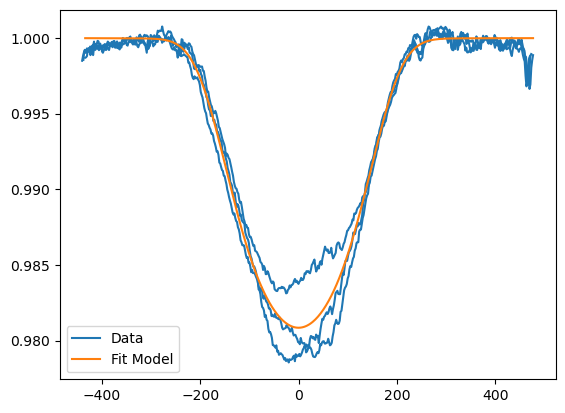

In [10]:
x1=DataPacket.original.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.original.lsds[0].specI
x2=DataPacket.original.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.original.lsds[1].specI
x3=DataPacket.original.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.original.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\pjsta\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:31<00:00,  3.21it/s]
C:\MyPythonPackages\pyRaven\fitparams.py:207: RuntimeWarning: invalid value encountered in divide
  bin_means = (np.histogram(kappa, bins, weights=kappa)[0]/np.histogram(kappa, bins)[0])
C:\MyPythonPackages\pyRaven\fitparams.py:210: RuntimeWarning: invalid value encountered in divide
  bin_means = (np.histogram(vsini, bins, weights=vsini)[0]/np.histogram(vsini, bins)[0])
C:\MyPythonPackages\pyRaven\fitparams.py:213: RuntimeWarning: invalid value encountered in divide
  bin_means = (np.histogram(vmac, bins, weights=vmac)[0]/np.histogram(vmac, bins)[0])


kappa: 1.259218729326427 | vsini: 97.37207023619489 | vmac: 84.73514804504917
Too few points to create valid contours


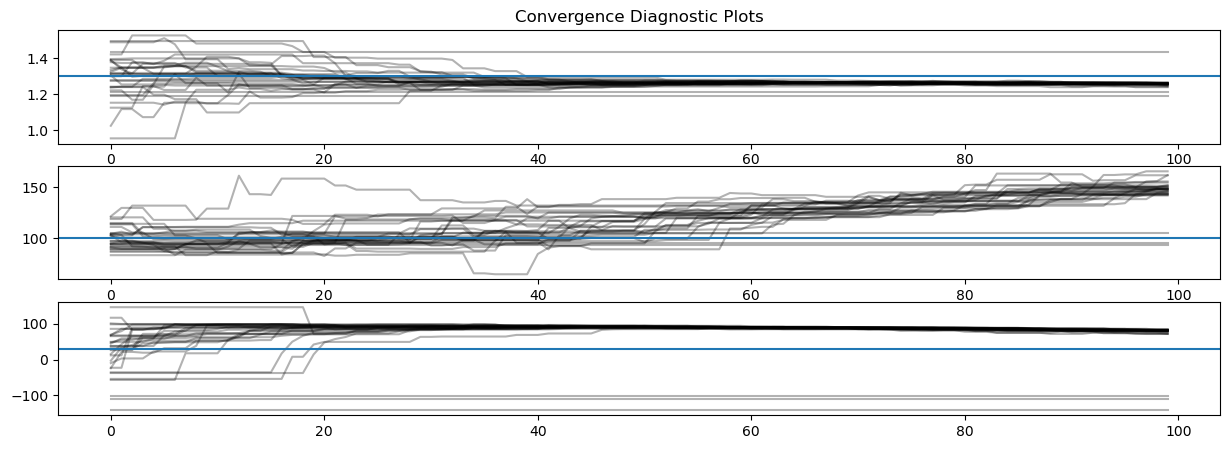

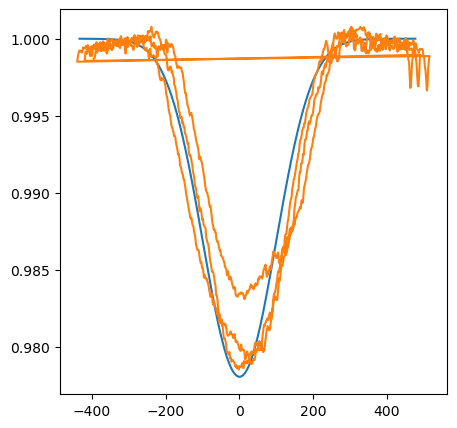

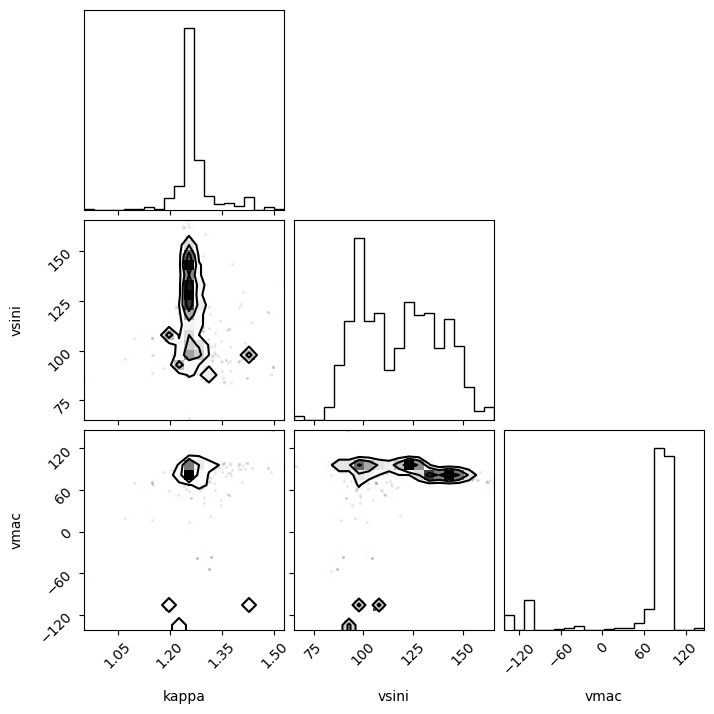

In [11]:
kappa,vsini,vmac,out=rav.fitparams.fitdataMCMC(param,DataPacket,100,guess)

Additionally, we can also perform a fit of kappa and vmac while keeping vsini fixed. This is done by using the `fitdata_novsini` function as done below.

In [13]:

guess=np.array([1.3,30])

parameters,covariance,modelout = rav.fitparams.fitdata_novsini(param,DataPacket,guess)


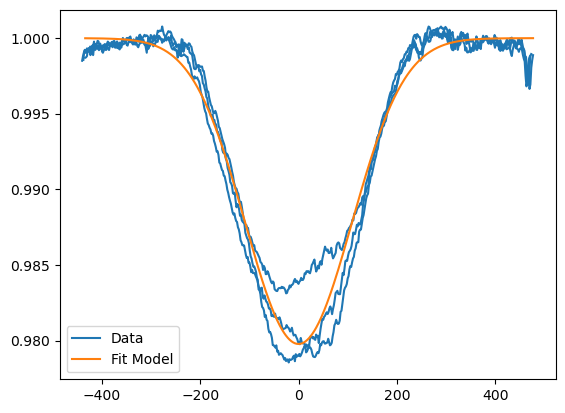

In [14]:
x1=DataPacket.original.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.original.lsds[0].specI
x2=DataPacket.original.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.original.lsds[1].specI
x3=DataPacket.original.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.original.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

## Below, dev still

In [12]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':50.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':0.98,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'Bpole':1000, #not necessary for loop
    'incl':30., #not necessary for loop
    'beta':30, #not necessary for loop
    'phase':90. #not necessary for loop
  }

unnoparam = {
    'down':[0, 0, 0],   # the s, j, l of the lower level
    'up':[0, 1, 1],    # the s, j, l of the upper level
    }

weakparam = {
        'geff':1.0
    }

gridparam = {
        'Bgrid': np.array([1000, 2000]),
        'igrid': np.array([30,60]),
        'betagrid':np.array([30]),
        'phasegrid':np.array([90])
        }
    
param={'general' : genparam,
       'weak' : weakparam,
       'grid' : gridparam,
       'unno': unnoparam # no necessary for loop
       }